# Halo - Vertical Lyapunov
In ths notebook we start from a trajectory that connects a Halo orbit to a vertical Lyapunov with one mid-course $\Delta V$ manouvre.
The trajectory was found by Flavio Tagliaferri and published in the corresponding ISSFD paper:

Tagliaferri, F. et al. "Global Optimization for Trajectory Design via Invariant Manifolds in the Earth-Moon Circular Restricted Three-Body Problem" - ISSFD 2024

co-authored by some of the authors of this notebook.

We start with needed imports ...

In [1]:
# Core imports
import numpy as np
import heyoka as hey
import time
import pickle as pkl

# Our module
import mit

# Plotting utilities
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

... and we reproduce the reference trajectory from the paper. Note that with respect to the initial conditions found in the original paper above cited, we have changed slightly the departure velocity as to eliminate the small $\Delta r$ resulting from the method there used.

Units are V=1023.2461077776794m/s and T=375,699.7937499362s

In [2]:
# Problem data
n_points = 500 # must be even
r0 = np.array([0.90336092,  0.06549106,  0.05997893])
v0 = np.array([ 0.0418146562792943, -0.2389225216655796,  0.1527203136115548])
rf = np.array([ 1.1320017586032516, -0.0052433393613869,  0.0252527208916375])
vf = np.array([ -0.0265974538841387, -0.0588418085073427,  0.2918462705026963])
DVn = np.array([ 0.0082427135437804,  0.0238438704231704, -0.0135572187828237])

tl=5.9398889573596145
tr=7.543375570274868

mu = 0.012150584269940356

# We separate the integration grid into left of the DV and right of the DV as to gain numerical stability. 
t_gridl = np.linspace(0, tl, int(n_points/2))
t_gridr = np.linspace(tl, tl+tr, int(n_points/2)+1)
t_grid = np.hstack((t_gridl, t_gridr[1:]))

# The DV is applied at tl
n=int(n_points/2)-1

### 1 - STMs, forward up to the DV (left)
We now integrate numerically the variational equations of the cr3bp dynamics and extract the relevant STMs. 
We do this first for grid points $i<n$ before the $\Delta V$ and up to the node $n$ where the DV is applied. 
This allows us to obtain STMs with good conditioning number and that keep the symplectic property, both things would be destroyed by numerical instabilities if we did a one only propagation
as in the case of the Keplerian dynamics.

In [3]:
 # First we instantiate the appropriate Taylor integrator:
ta = mit.ta_cr3bp_variational
mu = 0.012150584269940356
ta.pars[0] = mu
# Reset the start time to zero
ta.time = 0.0
# Reset the ic of the variational equation (for safety)
ic_var = np.eye(6).reshape((36,))
# Set the initial state
ta.state[:] = list(r0) + list(v0) + list(ic_var)
# Perform the propagation up to the DV (node n)
out = ta.propagate_grid(t_gridl)[-1]
# These are M0i from the initial to the i-th time grid point. Only for grid points before n
stms_0i_l = [out[i,6:].reshape(6,6) for i in range(len(t_gridl))]
M0n = stms_0i_l[-1]
# These are the STMs from points before the DV (left) to the point n where the DV is applied
stms_in_l = [M0n@mit.invMG(stms_0i_l[i]) for i in range(len(t_gridl))]

### 2 - STMs, backward up to the DV (right)
Here we integrate backward from the final point $f$ to the generic $i$ point in the grid but only for $i>n$.

In [4]:
# We invert the time grid as to be able to perform the propagation
t_grid_inv=t_gridr[::-1]
# Reset the integrator state
ta.state[:] = list(rf) + list(vf) + list(ic_var)
ta.time = tl+tr
# Propagate from the end to the DV
out_inv = ta.propagate_grid_variational(ta, t_grid_inv)
# Assemble the grid of STMs (avoiding to insert the point n 2 times) - here we reinvert the grid
stms_fi_r = [item[6:].reshape(6,6) for item in out_inv][::-1]
Mfn = stms_fi_r[0]
# These are now all well conditioned and we can invert
stms_if_r = [mit.invMG(M) for M in stms_fi_r]
Mnf = stms_if_r[-1]
# We compute the left part (from the forward integartion) to get if also for those grid points
stms_if_l = [Mnf@Min for Min in stms_in_l]
stms_if = stms_if_l + stms_if_r


Let us have a look at the trajectory.

DV: 29.31 m/s


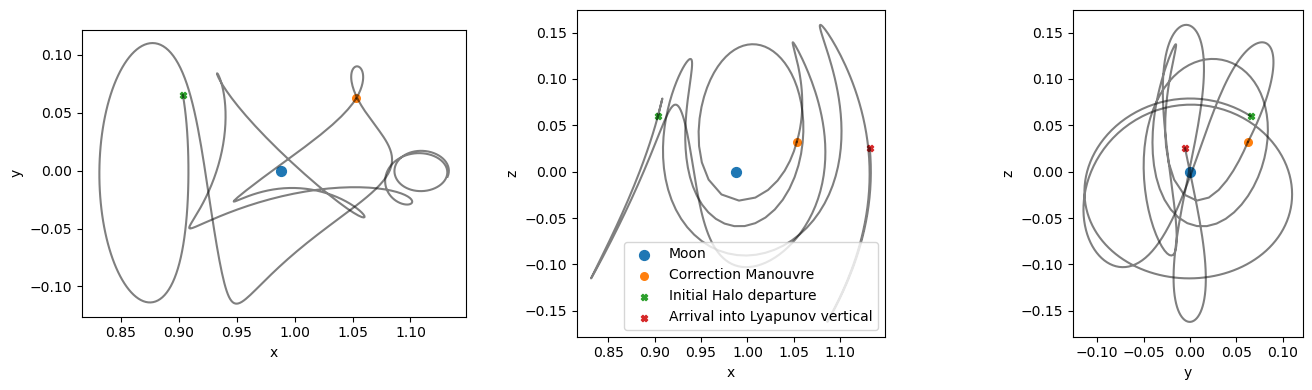

In [5]:
fig=plt.figure(figsize=(14,4))
axes = fig.subplots(nrows=1, ncols=3)

axes[0].plot(out[:,0], out[:,1], 'k', alpha=0.5)
axes[0].plot(out_inv[:,0], out_inv[:,1], 'k', alpha=0.5)

# The Moon and DV
axes[0].scatter(1-mu, 0, s=50)
axes[0].scatter(out[n,0], out[n,1], s=30)
axes[0].scatter(out[0,0], out[0,1], s=20, marker='X')

axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_aspect('equal', 'box')


axes[1].plot(out[:,0], out[:,2], 'k', alpha=0.5)
axes[1].plot(out_inv[:,0], out_inv[:,2], 'k', alpha=0.5)
# The Moon and DV
axes[1].scatter(1-mu, 0, s=50, label = "Moon")
axes[1].scatter(out[n,0], out[n,2], s=30, label = "Correction Manouvre")
axes[1].scatter(out[0,0], out[0,2], s=20, marker='X', label = "Initial Halo departure")
axes[1].scatter(out_inv[0,0], out_inv[0,2], s=20, marker='X', label = "Arrival into Lyapunov vertical")
axes[1].legend()

axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[1].set_aspect('equal', 'box')


axes[2].plot(out[:,1], out[:,2], 'k', alpha=0.5)
axes[2].plot(out_inv[:,1], out_inv[:,2], 'k', alpha=0.5)
# The Moon and DV
axes[2].scatter(0, 0, s=50)
axes[2].scatter(out[n,1], out[n,2], s=30)
axes[2].scatter(out[0,1], out[0,2], s=20, marker='X')
axes[2].scatter(out_inv[0,1], out_inv[0,2], s=20, marker='X')

axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
axes[2].set_aspect('equal', 'box')

fig.tight_layout()

print(f"DV: {np.linalg.norm(DVn) * 1023.2461077776794:2.2f} m/s")

plt.savefig("hetero_transfer.png", dpi=600)

And here we compute the surrogate primer vector condition

In [6]:
p = np.ones((n_points,n_points))
for idx_i in range(n_points):
    if idx_i==n:
            continue
    for idx_j in range(idx_i+1,n_points):
        if idx_j==n:
            continue
        Mif = stms_if[idx_i]
        Mjf = stms_if[idx_j]
        # We now premultiply by Mfn as to simplify the constraint equation
        Mi = Mfn@Mif
        Mj = Mfn@Mjf
        # And compute the Aij
        Mrvj = Mj[:3,3:]
        Mrvi = Mi[:3,3:]
        Mrvi_inv = np.linalg.inv(Mrvi)
        Mvvj = Mj[3:,3:]
        Mvvi = Mi[3:,3:]
        Aij = - Mrvi_inv@Mrvj
        Anj = - (Mvvi@Aij+Mvvj)
        # And B, b
        B = Aij
        b = - DVn@Anj / np.linalg.norm(DVn)
        # and solve
        a,sol = mit.minBu_bu_p(B, b)
        p[idx_i, idx_j] = np.inf
        p[idx_j, idx_i] = a


# Compute the best impulse directions

In [7]:
idx2, idx1 = np.unravel_index(p.argmin(), p.shape)

# We perform the computations again in correspondance of the best point
Mif = stms_if[idx1]
Mjf = stms_if[idx2]
Mi = Mfn@Mif
Mj = Mfn@Mjf
Mrvj = Mj[:3,3:]
Mrvi = Mi[:3,3:]
Mrvi_inv = np.linalg.inv(Mrvi)
Mvvj = Mj[3:,3:]
Mvvi = Mi[3:,3:]
Aij = - Mrvi_inv@Mrvj
Anj = - (Mvvi@Aij+Mvvj)
B = Aij
b = - DVn@Anj / np.linalg.norm(DVn)
a,sol = mit.minBu_bu_p(B, b)

uj = np.array(sol).reshape(3,1)
uj=uj/np.linalg.norm(uj)
dDVn = Anj@uj
dDVi = Aij@uj
ti = t_grid[idx1]
tj = t_grid[idx2]

print("Max of the primer conditions is at: ", ti, tj)
print("Max of the primer value is : ", -np.min(p))

print(f"\nMid course correction at: {tl}, dDVn is {dDVn.flatten()}")
print(f"First added impulse at: {ti}, dDVi is {dDVi.flatten()}")
print(f"Mid course correction at: {tj}, dDVj is {uj.flatten()}")


Max of the primer conditions is at:  6.211450477889509 7.6296050851011845
Max of the primer value is :  10.07712368579172

Mid course correction at: 5.9398889573596145, dDVn is [-10.43289117 -13.66556571  -0.7234478 ]
First added impulse at: 6.211450477889509, dDVi is [ 2.81820254 -0.50041345 -2.73653809]
Mid course correction at: 7.6296050851011845, dDVj is [ 0.61513423 -0.78064855 -0.11044326]


# Plotting the surrogate map

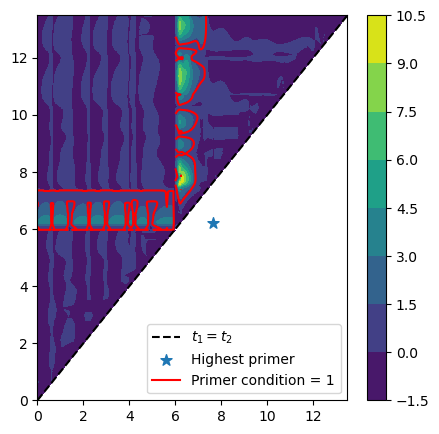

In [8]:
p_clean=p.copy()
# To avoid color saturation to represent areas where the primer condition is way too high
infs = (p_clean>10000) 
p_clean[p_clean > 1] = 1
p_clean[infs] = np.inf
p_clean=-p_clean

fig = plt.figure(figsize=(5,5))
X,Y = np.meshgrid(t_grid, t_grid)
plt.contourf(X,Y,p_clean)
plt.colorbar()
plt.contour(X,Y,p_clean, [1], colors='r', linestyles='solid')
plt.savefig("surrogate_primer_halo.png", dpi=600)
plt.plot(t_grid,t_grid, 'k--', label="$t_1=t_2$")
plt.scatter(t_grid[idx2], t_grid[idx1], label="Highest primer", marker="*", s=70)
plt.plot([],[], 'r', label="Primer condition = 1")
plt.legend(loc="lower right")

plt.savefig("hetero_transfer_s.png", dpi=600)